## FDS (Fraud Detection System, 이상금융거래탐지시스템)

### Module import

In [35]:
import os, shutil, gc
import multiprocessing
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.python.estimator.model_fn import ModeKeys as Modes
from tensorflow.contrib.learn import Experiment
from tensorflow.contrib.learn.python.learn import learn_runner
from tensorflow.contrib.learn.python.learn.utils import (saved_model_export_utils)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno

from sklearn import metrics, preprocessing
from sklearn.preprocessing import Imputer, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, preprocessing
from sklearn.decomposition import PCA
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

tf.logging.set_verbosity(tf.logging.INFO)
OUTDIR='./tmp/trained_model'

### Reduce Memory Usage

In [2]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Wall time: 0 ns


### Load CSV file

In [3]:
train_tr = pd.read_csv('./input/train_transaction.csv', index_col='TransactionID')
print("Completed load")
train_id = pd.read_csv('./input/train_identity.csv', index_col='TransactionID')
print("Completed load")
test_tr = pd.read_csv('./input/test_transaction.csv', index_col='TransactionID')
print("Completed load")
test_id = pd.read_csv('./input/test_identity.csv', index_col='TransactionID')
print("Completed load")
sub = pd.read_csv('./input/sample_submission.csv', index_col='TransactionID')
print("Completed load")

Completed load
Completed load
Completed load
Completed load
Completed load


### Left join by TransactionId

In [4]:
train = pd.merge(train_tr, train_id,
                        how='left',
                        on='TransactionID')
del train_tr, train_id

test = pd.merge(test_tr, test_id,
                        how='left',
                        on='TransactionID')
del test_tr, test_id

train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)

Memory usage of dataframe is 1955.37 MB
Memory usage after optimization is: 527.82 MB
Decreased by 73.0%
Memory usage of dataframe is 1673.87 MB
Memory usage after optimization is: 460.15 MB
Decreased by 72.5%


### EDA(Exploratory Data Analysis)
* Except for three variables with very large variance, all variables are treated as objects.

In [5]:
# msno.heatmap(train.iloc[:, :5])
# msno.matrix(df=train.iloc[:, 61:80], figsize=(20, 20), color=(0.2, 0.3, 0.8))

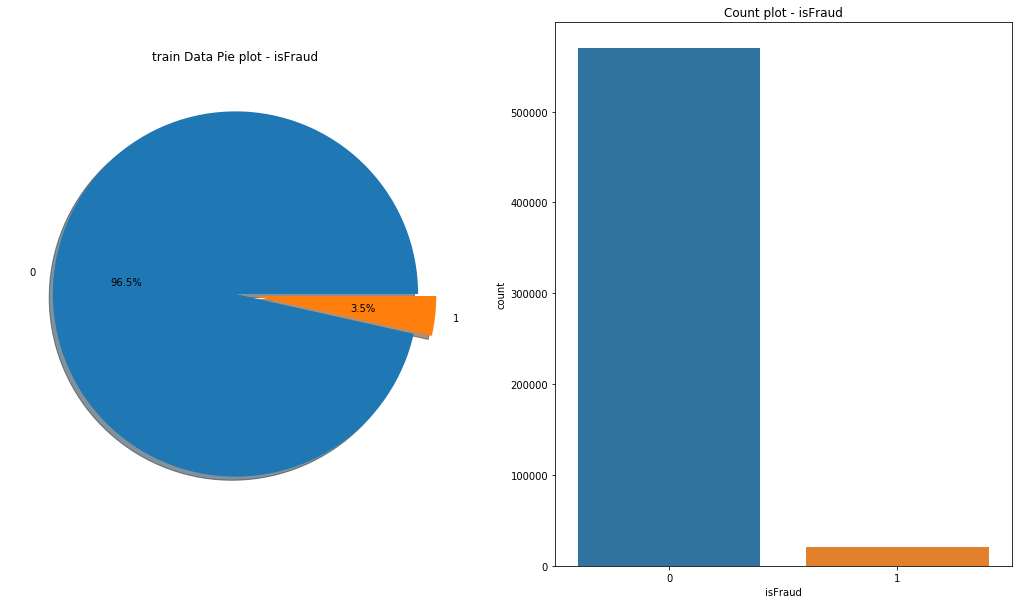

In [8]:
def fraud_ratio_pie(df, s):
    ###Test data Fraud ratio pie chart
    f, ax = plt.subplots(1, 2, figsize=(18, 10))

    df['isFraud'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title('{} Data Pie plot - isFraud'.format(str(s)))
    ax[0].set_ylabel('')
    sns.countplot('isFraud', data=df, ax=ax[1])
    ax[1].set_title('Count plot - isFraud')

    plt.show()
fraud_ratio_pie(train,'train')

In [20]:
def covert_to_object(df):
    # covert to object for reuse
    df['ProductCD'] = df['ProductCD'].astype('object')
    df['P_emaildomain'] = df['P_emaildomain'].astype('object')
    df['R_emaildomain'] = df['R_emaildomain'].astype('object')    
    df['DeviceType'] = df['DeviceType'].astype('object')
    df['DeviceInfo'] = df['DeviceInfo'].astype('object')

    card_cols = [c for c in df.columns if 'card' in c]
    for col in card_cols:
        df[col] = df[col].astype('object')

    addres_cols = [c for c in df.columns if 'addr' in c]
    for col in addres_cols:
            df[col] = df[col].astype('object')

    M_cols = [c for c in df.columns if 'M' in c]
    for col in M_cols:
            df[col] = df[col].astype('object')

    C_cols = [c for c in df.columns if 'C' in c]
    for col in C_cols:
            df[col] = df[col].astype('object')

    id_cols = [c for c in df.columns if 'id' in c]
    for col in id_cols:
            df[col] = df[col].astype('object')
            
covert_to_object(train)
covert_to_object(test)

Text(0.5, 1.0, 'TransactionAmt Distribution')

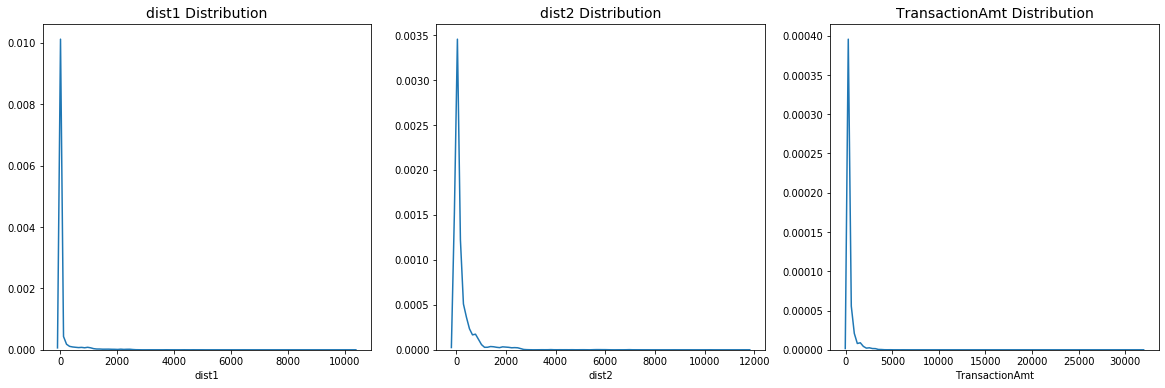

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))
ax = sns.distplot(train['dist1'].dropna(axis = 0), bins=10, hist=False, ax=ax1)
ax1.set_title('dist1 Distribution', fontsize=14)

ax = sns.distplot(train['dist2'].dropna(axis = 0), bins=10, hist=False, ax=ax2)
ax2.set_title('dist2 Distribution', fontsize=14)

ax = sns.distplot(train['TransactionAmt'].dropna(axis = 0), bins=2, hist=False, ax=ax3)
ax3.set_title('TransactionAmt Distribution', fontsize=14)

### Imputation of missing values

In [11]:
def missing_values_check(df):
    missing_values_mean = df[df.columns].isnull().mean()
    print (missing_values_mean.head())
#     total_cells = np.product(df.shape)
#     total_missing = missing_values_count.sum()
    print ("Percentage of Missing data = ", missing_values_mean * 100)

In [12]:
def missing_values_categorical(df, threshold=100.00): 
    missing_percentage= df[df.columns].isnull().mean() * 100
    columns = missing_percentage[missing_percentage<threshold].index
    df = df[columns]
    
    features_categorical = df.select_dtypes(include = ['object']).columns
    df[features_categorical] = df[features_categorical].fillna('-999',inplace=False)
    
    missing_values_check(df)
    
    del features_categorical
    
    return df

In [13]:
def missing_values_numerical(df, threshold=100.00): 
    missing_values_count = df.isnull().sum()
    missing_percentage= df[df.columns].isnull().mean() * 100
    columns = missing_percentage[missing_percentage<threshold].index
    df = df[columns]
    
    features_dist_transAmt = df[['dist1','dist2','TransactionAmt']].columns
    
    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imputer = imputer.fit(df[features_dist_transAmt])
    
    df = imputer.transform(df[features_dist_transAmt])
    df = pd.DataFrame(df, columns=['dist1','dist2','TransactionAmt'])
    
    del features_dist_transAmt
    
    return df

In [14]:
print ("Train data missing = ",(train[train.columns].isnull().sum().sum()/np.product(train.shape)) * 100,"%")

Train data missing =  45.178469762399324 %


In [ ]:
def data_cleansing(df, threshold=100.0): 
    features_numeric = \
        df.select_dtypes(include = ['int8', 'int32', 'int64','float16','float64']).columns
    col_1 = [c for c in features_numeric if c in ['dist1','dist2','TransactionAmt']]
    col_2 = [c for c in features_numeric if c not in col_1] #V1~, M1~, D1~

    s = df.index
    df_clean_col_1 = missing_values_numerical(df[col_1], threshold)
    df_clean_col_1 = df_clean_col_1.set_index([s])

    df_clean_col_2 = df[col_2].fillna(-999)
    df_clean_col_2 = df_clean_col_2.set_index([s])

    #Numerical cleanse
    df_clean_N = \
        df_clean_col_1.merge(df_clean_col_2, left_on='TransactionID', right_on='TransactionID', how='left')
    del df_clean_col_1, df_clean_col_2
    #missing_values_check(df_clean_N)
    
    df_clean_C = missing_values_categorical(train[features_category], threshold)
    #train_clean_C['card1'] = train_clean_C['card1'].astype('object')
    #missing_values_check(train_clean_C)
    
    #Categorical cleanse
    df_clean = \
     df_clean_N.merge(df_clean_C, left_on='TransactionID', right_on='TransactionID', how='left')
    
    del df_clean_N, df_clean_C
    
    return df_clean

train_clean = data_cleansing(train,100.0)
test_clean  = data_cleansing(test,100.0)

print(train_clean.isnull().sum())
print(test_clean.isnull().sum())

In [ ]:
# print(train_clean.isnull().sum())
# print(test_clean.isnull().sum())

In [ ]:
#missing_values_check(train_clean_C)


In [ ]:

# del train

### TransactionDT guess

In [ ]:
START_DATE = '2018-01-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train_clean['TransactionDT'] = \
    train_clean['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
# print(train_clean.head())
# print(train_clean.tail())

### Feature Scaling
* dist1, dist2, TransactionAmt
* downscale with log, plus 1 for preventing log error

In [ ]:
#Before scaling
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 10))
ax = sns.distplot(train_clean['dist1'].dropna(axis = 0), bins=10, hist=False, ax=ax1)
ax1.set_title('dist1 Distribution', fontsize=14)

ax = sns.distplot(train_clean['dist2'].dropna(axis = 0), bins=10, hist=False, ax=ax2)
ax2.set_title('dist2 Distribution', fontsize=14)

ax = sns.distplot(train_clean['TransactionAmt'].dropna(axis = 0), bins=2, hist=False, ax=ax3)
ax3.set_title('TransactionAmt Distribution', fontsize=14)

In [ ]:
"""
The overall scaling results are similar, 
but RobustScaler is less prone to outliers.
"""
def feature_scaling(df_clean): 

     #downscale, preventing log error
    df_clean['dist1'] = np.log(df_clean['dist1']+1)
    df_clean['dist2'] = np.log(df_clean['dist2']+1)
    df_clean['TransactionAmt'] = np.log(df_clean['TransactionAmt']+1)

    cols_1 = [c for c in df_clean.columns if c in ['dist1','dist2','TransactionAmt']]
    cols_2 = [c for c in df_clean.columns if c not in cols_1]

    rob_scaler = RobustScaler(with_scaling=True, with_centering=False)
    df_clean_rob = \
        pd.DataFrame(data=rob_scaler.fit_transform(df_clean[cols_1]), columns=['dist1','dist2','TransactionAmt'])

    # Set the index of the scaled dataset. It is the same as the original dataset
    s = df_clean.index
    df_clean_rob = df_clean_rob.set_index([s])

    #Merge the scaled dataset with the categorical features and the cleaned dataset with scaled numerical columns
    df_clean_rob = \
        pd.merge(df_clean_rob, df_clean[cols_2],left_index=True, right_index=True)

    #Check dimensions.
    print(df_clean.shape)
    print(df_clean_rob.shape)
    
    return df_clean_rob
train_clean_rob = feature_scaling(train_clean)
test_clean_rob  = feature_scaling(test_clean)

del train_clean, test_clean
gc.collect()

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))
ax = sns.distplot(train_clean_rob['dist1'], bins=10, hist=False, ax=ax1)
ax1.set_title('dist1 Distribution After Scaling', fontsize=14)

ax = sns.distplot(train_clean_rob['dist2'], bins=10, hist=False, ax=ax2)
ax2.set_title('dist2 Distribution After Scaling', fontsize=14)

ax = sns.distplot(train_clean_rob['TransactionAmt'], bins=2, hist=False, ax=ax3)
ax3.set_title('TransactionAmt Distribution After Scaling', fontsize=14)
# train_clean_rob.head()
# train_clean.columns

### Transaction amount comparison fraud and non-fraud

In [ ]:
f,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(12,6))

ax1.hist(train_clean_rob.TransactionAmt[train_clean_rob.isFraud==1],bins=30)
ax1.set_title('Fraud')

ax2.hist(train_clean_rob.TransactionAmt[train_clean_rob.isFraud==0],bins=30)
ax2.set_title('Non-Fraud')

plt.xlabel('TransactionAmt($)')
plt.ylabel('Number of transaction')
plt.yscale('log')
plt.show()

### Distribution of features between Fraud & non-Fraud

In [ ]:
# #Distribution histogram of features
# print(train_clean.columns)
# features = train_clean.ix[:,4:5].columns;


# for i,cn in enumerate(train_clean[features]):
#     print("i: ",i)
#     print("cn: ",cn)
#     fig =  plt.figure(figsize=(20,12))
#     ax = fig.add_subplot(111)
#     sns.distplot(train_clean[cn][train_clean.isFraud == 1], bins=50,color='r')
#     sns.distplot(train_clean[cn][train_clean.isFraud == 0], bins=50,color='b')
#     ax.set_xlabel('')
#     ax.set_title('histogram of feature: ' + str(cn))
#     plt.savefig('./output/pics/histgram of {}.png'.format(str(cn)))
#     plt.clf()
# #plt.show()

### Data Split

#### 1. Data Split for LogisticRegression()
* Normal data is divided into for learning and testing, and for testing at a ratio of 70:30

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3,shuffle = False )

#gc.collect()

#### 2. Data Split for AutoEncoder
* Normal data is divided into for learning, testing, and testing at a ratio of 60:20:20, and abnormal data is not used for learning and is used only for testing and verification, so it divides into 50:50 ratio for testing and verification

In [81]:
# split non_fraud by 60%,20%,20% (training, validation, test )

df_nonfraud = train_clean_rob[train_clean_rob.isFraud == 0.0]
df_fraud = train_clean_rob[train_clean_rob.isFraud == 1.0]

#Non Fraud Datasets
df_nonfraud_train,df_nonfraud_validate,df_nonfraud_test = \
    np.split(df_nonfraud,[int(0.6*len(df_nonfraud)),int(0.8*len(df_nonfraud))])

#Fraud Datasets (Just for validation, test)
df_fraud_validate,df_fraud_test = \
    np.split(df_fraud,[int(0.5*len(df_fraud))])

del df_nonfraud, df_fraud
gc.collect()

#Merge datas and Shufflling for train
df_train = df_nonfraud_train.sample(frac=1) 
df_validate = df_nonfraud_validate.append(df_fraud_validate).sample(frac=1)
df_test = df_nonfraud_test.append(df_fraud_test).sample(frac=1)

del df_nonfraud_train,df_nonfraud_validate,df_nonfraud_test,df_fraud_validate,df_fraud_test
gc.collect()




44

#### df[-1] == Fraud column

In [ ]:
def fraud_label_mov(df): 
    cols = df.columns.tolist()
    tmpcols = cols[3:4]
    cols = cols[:3] + cols[4:] 
    cols = cols[:] + tmpcols
    df= df[cols]
    return df
fraud_label_mov(df_train)
fraud_label_mov(df_validate)
fraud_label_mov(df_test)

In [99]:
df_train.to_csv("./cleaned/cleaned_train.csv", mode='w', index=False)
df_validate.to_csv("./cleaned/cleaned_validate.csv", mode='w', header=False)
df_test.to_csv("./cleaned/cleaned_test.csv", mode='w', header=False)

In [95]:
# # df_train.iloc[:,388:389].unique()

<bound method DataFrame.count of Empty DataFrame
Columns: [dist1, dist2, TransactionAmt, isFraud, TransactionDT, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51, V52, V53, V54, V55, V56, V57, V58, V59, V60, V61, V62, V63, V64, V65, V66, V67, V68, V69, V70, V71, V72, V73, V74, V75, V76, V77, V78, V79, V80, ...]
Index: []

[0 rows x 389 columns]>

In [ ]:
# corr_with_Fraud = train.corrwith(train['isFraud'])
# for d in corr_with_Fraud:
#     if(d > 0.01):
#         print((corr_with_Fraud==d).argmax(), d)


In [ ]:
# corr_with_Fraud = train.corrwith(train['isFraud'])
# print(corr_with_Fraud)

In [ ]:
# X2= np.array(X)
# y = np.array(y)

# X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3,shuffle = False )
# print(X2.shape)
# print(y.shape)


In [ ]:
# print(X_train)

In [ ]:
# print(y_train[:])

## Modeling

### 1. LogisticRegression()

In [ ]:
# glm = LogisticRegression()
# glm.fit(X_train, y_train[:])
# y_pred = glm.predict(X_test)
# acc = np.mean(y_test[:] == y_pred )
# print("SKLEARN Logistic Regression Accuracy = {:3.3f}".format(acc))

### 2. AutoEncoder

In [97]:
#def split_value_label(filename_queue):
def read_and_decode(filename_queue):
    reader = tf.TextLineReader()
    key,value = reader.read(filename_queue)
    record_defaults = [ [0.0] ]*390
    columns = tf.decode_csv(value,record_defaults = record_defaults)
    #print(columns[0:59])
    # first column is time field from 1 to 28 column is feature, 2
    value = tf.convert_to_tensor(columns[1:388],dtype=tf.float32)
    value.set_shape([387])
    label =tf.cast( columns[388],tf.int32)
    
    return value,label

def input_fn(filename,batch_size=100):
    filename_queue = tf.train.string_input_producer([filename])
    
    value,label = read_and_decode(filename_queue)
    values,labels = tf.train.batch(
        [value,label],batch_size=batch_size,
        capacity = 1000+3*batch_size)
    return {'inputs':values},labels

def get_input_fn(filename,batch_size=100):
    return lambda: input_fn(filename,batch_size)

def serving_input_fn():
    inputs = {'inputs':tf.placeholder(tf.float32,[None,387])}
    return tf.estimator.export.ServingInputReceiver(inputs,inputs)

def autoencoder_model_fn(features,labels,mode):
    input_layer = features['inputs']
    dense1 = tf.layers.dense(inputs=input_layer,units=380,activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1,units=370,activation=tf.nn.relu)
    dense3 = tf.layers.dense(inputs=dense2,units=360,activation=tf.nn.relu)
    dense4 = tf.layers.dense(inputs=dense3,units=370,activation=tf.nn.relu)
    dense5 = tf.layers.dense(inputs=dense4,units=380,activation=tf.nn.relu)
    output_layer = tf.layers.dense(inputs=dense5,units=387,activation=tf.nn.sigmoid)
    
    #training and evaluation mode
    if mode in (Modes.TRAIN,Modes.EVAL):
        global_step = tf.contrib.framework.get_or_create_global_step()
        label_indices = tf.cast(labels,tf.int32)
        loss = tf.reduce_sum(tf.square(output_layer - input_layer))
        tf.summary.scalar('OptimizeLoss',loss)

        if mode == Modes.TRAIN:
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
            train_op = optimizer.minimize(loss,global_step=global_step)
            return tf.estimator.EstimatorSpec(mode,loss = loss, train_op = train_op)
        if mode == Modes.EVAL:
            eval_metric_ops = None
            return tf.estimator.EstimatorSpec(
                mode,loss=loss,eval_metric_ops = eval_metric_ops)
        
    # prediction mode
    if mode == Modes.PREDICT:
        predictions={
            'outputs':output_layer
        }
        export_outputs={
            'outputs':tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(
            mode,predictions=predictions,export_outputs=export_outputs)

def build_estimator(model_dir):
    return tf.estimator.Estimator(
        model_fn = autoencoder_model_fn,
        model_dir = model_dir,
        config=tf.contrib.learn.RunConfig(save_checkpoints_secs=180))

def generate_experiment_fn(data_dir,
                          train_batch_size = 100,
                          eval_batch_size = 100,
                          train_steps = 20000,
                          eval_steps = 1,
                          **experiment_args):
    def _experiment_fn(output_dir):
        return Experiment(
            build_estimator(output_dir),
            train_input_fn=get_input_fn('./cleaned/cleaned_train.csv',batch_size=train_batch_size),
            eval_input_fn=get_input_fn('./cleaned/cleaned_test.csv',batch_size=eval_batch_size),
            export_strategies = [saved_model_export_utils.make_export_strategy(
                serving_input_fn,
                default_output_alternative_key=None,
                exports_to_keep=1)
            ],
            train_steps = train_steps,
            eval_steps = eval_steps,
            **experiment_args
        )
    return _experiment_fn

shutil.rmtree(OUTDIR, ignore_errors=True) # start fresh each time
learn_runner.run(
    generate_experiment_fn(
        data_dir='./cleaned/',
        train_steps=5000),OUTDIR)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023796188AC8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 180, '_log_step_count_steps': 100, '_protocol': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './tmp/trained_model'}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:t

InvalidArgumentError: Field 0 in record 0 is not a valid float: TransactionID
	 [[{{node DecodeCSV}}]]

### 3. GAN